# Topic Map

In [1]:
import os
import pandas as pd
import re
import nltk
import openai
import matplotlib
import matplotlib.pyplot as plt
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from bertopic import BERTopic
from nltk import sent_tokenize, word_tokenize
# nltk.download('punkt') < uncomment when you run it first time


pd.set_option('display.max_colwidth', None)
data_dir = '../data/'
processed_dir = data_dir + 'processed/'
os.makedirs(processed_dir + 'html', exist_ok = True)
os.makedirs(processed_dir + 'topic-map', exist_ok = True)
transcription_dir_location_en = processed_dir + 'transcription/en/'

In [26]:
docs = []
filename = []
timestamps = []
docs_word_count = []
# TODO sort by date

# the text contains spoken filler words that need removed 
stopwords = ['um', 'um,', 'mm,', 'eh', 'eh,', 'eh?', 'ah', 'ah,', 'mhm', 'mhm.', 'oh', 'oh,', 'oh.', 'huh?', 'hi']     
# RegExs for significant phrases 
FDI = re.compile(re.escape("fratelli d'italia"), re.IGNORECASE)
ninety_four = re.compile(re.escape("ninety four"), re.IGNORECASE)
one_hundred_and_ninety_four = re.compile(re.escape("one hundred and ninety-four"), re.IGNORECASE)

def remove_stop_words(sentence):
    text_tokens = sentence.split(" ")
    tokens_filtered = [word for word in text_tokens if not word.lower() in stopwords]
    return (" ").join(tokens_filtered)

def parse_text(file_location): 
    transcriptions_df = pd.read_json(file_location, convert_dates=['createTime'])
    transcription_text = transcriptions_df['transcript'][0]
    transcription_create_time = transcriptions_df['createTime'][0].strftime('%Y-%m-%d %H:%M:%S')
    word_count = len(transcription_text.split()) 
    # only analyse files with sentences with more then 27 words
    if word_count < 27:
        print(f'Small number of words: {file_location} {transcription_text}')
        return
    docs_word_count.append(word_count)
    for sentence in sent_tokenize(transcription_text):
        timestamps.append(transcription_create_time)
        sentence = FDI.sub('Brothers of Italy', sentence)
        sentence = ninety_four.sub('ninety-four', sentence)
        sentence = one_hundred_and_ninety_four.sub('194', sentence)
        sentence = remove_stop_words(sentence)                 
        docs.append(sentence)
    
for file_name in os.listdir(transcription_dir_location_en):
    parse_text(transcription_dir_location_en + file_name)

print(len(timestamps))
print(len(docs))

docs_dict = zip(timestamps, docs)
    
with open(processed_dir + '/topic-map/all-docs-text.txt', 'w') as file: 
	file.writelines("% s % s\n" % (key, value) for key, value in docs_dict) 

word_count_df = pd.DataFrame(zip(timestamps, docs_word_count), columns=['timestamp','word_count'])  
word_count_df.to_json(processed_dir + '/wordcount.json')

start_date = '2022-07-21'
end_date = '2022-09-26'

docs_df = pd.DataFrame(zip(timestamps, docs), columns=['timestamp','docs'])  

mask = (docs_df['timestamp'] > start_date) & (docs_df['timestamp'] <= end_date)
election_dates_df = docs_df.loc[mask]


Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147206448232074502.json gentlemen, It was the day of defeat. But this is not the day to get things done. Well, that wasn't really the case. That's fine. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147263913200045317.json September twenty-fifth I've said it all. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7135145359629634822.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144425341279341830.json I am
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7070073900100521222.json who goes M design, yo. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144420910336953606.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7143163842665663749.json 
Small number of words: ../data/processed/transcription/en/Transcribe

1) Pre-calculate Embeddings

In [3]:
from bertopic.backend import OpenAIBackend

# all-mpnet-base-v2 - id the best embedding model but slow
embedding_model = SentenceTransformer('all-mpnet-base-v2')
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

Stochastic Behaviour

In [23]:
from bertopic import BERTopic
from sklearn.decomposition import PCA

# umap_model = PCA()
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=42)

Limit Number of Topics

In [82]:
hdbscan_model = HDBSCAN(
    min_cluster_size=10, 
    metric='euclidean', 
    cluster_selection_method='eom', 
    min_samples=8, # added to reduce outliers
    prediction_data=True)

Improving Default Representation

In [6]:
# max_df 0.7, 1.0 no english stop wrods
# vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
#  stop_words="english" - seems to interfere with generating topics like 'abortion' and max_df=2, min_df=2, no idea what to tweak these to. 
vectorizer_model = CountVectorizer(stop_words="english")
# 
# vectorizer_model.fit_transform(docs)
# vectorizer_model.get_feature_names_out()

In [90]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)


# GPT-3.5
openai.api_key=os.environ['openai_api_key'] 
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

from bertopic.representation import ZeroShotClassification

candidate_topics = [
    'migrants', 
    # 'immigration',
    'abortion', 
    'fake news', 
    'Brothers of Italy', 
    'we are ready',
    'rape',
    'Nazis',
    'minimum wage',
    'ecological',
    'green pass',
    'russia'
    'crime', # this is used to separate out crime from migration
    'authoritarian',
    
    'women',
    # 'crime', 

    'inflation', 
    'citizenship', 
    'freedom',
    'prices',
    'pensions',
    'tax',
    'family',
    # 'government'    
    ]

zero_shot_model = ZeroShotClassification(candidate_topics, model="facebook/bart-large-mnli")

# representation_model = zero_shot_model

representation_model = {
    "Main": zero_shot_model,
    'KeyBERT': keybert_model,
    # 'OpenAI': openai_model,  # Uncomment if you will use OpenAI
    'MMR': mmr_model,
    # 'POS': pos_model,
    # 'ZeroShot': zero_shot_model,
}

## Seed Topics

In [44]:
seed_topic_list = [  
    ['Brothers of Italy', 'brothers of italy', 'Italy', 'Italian'],
    ['we are ready'], # The FDI's Campaign slogan     
    ['immigration', 'migration', 'migrants', 'refugee', 'traffickers'],
    ['abortion', 'abort', '194', 'law 194'],
    ['election', 'government', 'vote'],
    ['inflation', 'bills'],
    ['freedom'],
    ['rape', 'raped'],
    ['women'],

    
    ['climate' , 'environmental', 'ecological',  'sustainability'],
    ['fake', 'fake news', 'lies', 'journalism'],
    ['tax', 'income'],
    ['crime'],
    ['minimum wage'],
    ['Nazis', 'nazis'],
    ['pensions'],
    ['family', 'families'],
    ['pets', 'animals'], # added as pets get merge into the migrants topic    
    ['russia']       
    ]

In [132]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)

topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  # vectorizer_model=                       # Step 4 - Tokenize topics. Don't do this! It removed the entire abortion topic.
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  seed_topic_list= seed_topic_list,
  min_topic_size=10, # 10 is the default nope
  nr_topics=29, # 32
  verbose=True,
  n_gram_range=(1,3), # allows Brothers of Italy
  calculate_probabilities=True,
)

topics, probs = topic_model.fit_transform(docs)
topic_labels = topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=20, separator=', ')
topic_model.set_topic_labels(topic_labels)
# 889 outliers
topic_model.get_topic_info()

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

2023-10-23 09:30:13,472 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-10-23 09:30:23,208 - BERTopic - Reduced dimensionality
2023-10-23 09:30:23,468 - BERTopic - Clustered reduced embeddings
2023-10-23 09:36:25,087 - BERTopic - Reduced number of topics from 51 to 29


,Topic,Count,Name,CustomName,Representation,KeyBERT,MMR,Representative_Docs
0,-1,889,-1_government_have_this_we,"government, have, this","[government, have, this, we, are, in, on, be, of the, our]","[italy, government, the government, that we, for the, for, what, are, we, to the]","[government, have, this, we, are, in, on, be, of the, our]","[From the decree to protect strategic production sectors to the birth of the Committee for Made in Italy, passing through the battle that allowed us to avoid the exclusion of wine, red meat and cured meats from European funding for the promotion of agricultural products, we have reiterated that Italy intends to defend its infrastructure, its brand, its excellence from the two billion euros that we have allocated to interventions for the safety, adaptation and redevelopment of schools, of which seven hundred and ten million that we have released and one billion and two hundred million added from scratch until resources are increased to make universities more efficient for a total of one billion four hundred million., Let's say that we made a couple of jokes and I told her on the question of Emilia Romagna that I had responded with a long letter to the continuous complaints of President Bonaccini which in my opinion are poorly founded and that on the question of De Angelis I don't think I have to deal with the communication manager of the Region because I think it is the responsibility of the President of the Region, he considers the sixty days a commitment on the part of the government to close the issue of the instruments that I have formalized with the President of the CNEL and they guarantee me that they are able to do this work in sixty days., And obviously it also happened that the bubble inflated so much that at a certain point those who had these credits, mainly companies, could no longer compensate them because they had exhausted, let's say, their possibility of compensating that credit with taxes and could no longer not even to sell them, because even the fiscal drawers of the banks of the other actors who could buy those credits have closed and there are perfectly honest people who have done some work, who have trusted the State, who have done what the State said which found itself in the hands of some work done and money that it cannot take because this has produced this very interesting free measure that today we have thousands of companies that risk collapse and therefore since we inherited it, we now have to look for a solution to prevent thousands of companies from risking collapse because someone could say during the election campaign that they renovated houses for free and that's exactly what we tried to do.]"
1,0,234,0_italy_brothers of italy_of italy_brothers,"italy, brothers of italy, of italy","[italy, brothers of italy, of italy, brothers, brothers of, italian, italians, italy is, italy has, in italy]","[which italy, of italy, italy in, italy, italy is not, italy is, the italian, italy and, brothers of italy, that italy]","[italy, brothers of italy, of italy, brothers, brothers of, italian, italians, italy is, italy has, in italy]","[I can speak very badly about Italy, but I do it in my home, I do it in parliament, I do it with my opponents, I do it with the Italians at home, but outside you won't hear me speaking badly about Italy, I have done something interview with fox news and I didn't do it to speak badly of Italy in case the left won, I did it to say what I want to do, I did it to explain that this nation can get back on its feet, that this nation it can still be a proud nation, it can be a nation that amazes, as it has amazed throughout its history throughout its civilization., This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask 

### Merge, rename and format topics

Merge redundant blocks topics with outliers - expect it worked at the start and no longer works now. 

In [93]:

# topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
# topic_model.get_topic_info().head()

In [133]:
# outliers 
# realize       = [-1, 6]    # realize, what you ar
# heard         = [-1, 17]    # ve heard, what
# what          = [-1, 21]   # what you are
# we            = [-1, 26]    # we are
# what            = [-1, 3]     # what are, serious,
yes             = [-1, 11]    # yes, yes yes
thanks          = [-1, 14]    # you thank, you
good_morning    = [-1, 23]    # good morning
why             = [-1, 27]    # why, why why

topics_to_merge = [-1, 11, 14, 23, 27]
print(topics_to_merge)
topic_model.merge_topics(docs, topics_to_merge=topics_to_merge)     
topic_model.get_topic_info().head()

[-1, 11, 14, 23, 27]


,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,982,-1_government_have_we_you,"[government, have, we, you, in, this, that, are, on, of the]","[italy, government, the government, to the, that we, are, those who, what, for the, work]","[government, have, we, you, in, this, that, are, on, of the]","[From the decree to protect strategic production sectors to the birth of the Committee for Made in Italy, passing through the battle that allowed us to avoid the exclusion of wine, red meat and cured meats from European funding for the promotion of agricultural products, we have reiterated that Italy intends to defend its infrastructure, its brand, its excellence from the two billion euros that we have allocated to interventions for the safety, adaptation and redevelopment of schools, of which seven hundred and ten million that we have released and one billion and two hundred million added from scratch until resources are increased to make universities more efficient for a total of one billion four hundred million., And this is the reason why today I sent a letter to the European Council and the European Commission to ask that what we discussed at the last Ukrainian European Council meeting be immediately made concrete, we saw her moved in front of the children's soft toys killed on the bus and you confirmed to Zaleski the full support of the Italian government, despite an important part of public opinion being against the sending of weapons, I was moved by some soft toys in the rain in memory of some children because my daughter has some a similar one and however I also want to tell you that I thought that Italians should be very proud of them instead., And obviously it also happened that the bubble inflated so much that at a certain point those who had these credits, mainly companies, could no longer compensate them because they had exhausted, let's say, their possibility of compensating that credit with taxes and could no longer not even to sell them, because even the fiscal drawers of the banks of the other actors who could buy those credits have closed and there are perfectly honest people who have done some work, who have trusted the State, who have done what the State said which found itself in the hands of some work done and money that it cannot take because this has produced this very interesting free measure that today we have thousands of companies that risk collapse and therefore since we inherited it, we now have to look for a solution to prevent thousands of companies from risking collapse because someone could say during the election campaign that they renovated houses for free and that's exactly what we tried to do.]"
1,0,234,0_italy_brothers of italy_of italy_brothers,"[italy, brothers of italy, of italy, brothers, brothers of, italian, italians, italy is, italy has, in italy]","[which italy, of italy, italy in, italy, italy is not, italy is, the italian, italy and, brothers of italy, that italy]","[italy, brothers of italy, of italy, brothers, brothers of, italian, italians, italy is, italy has, in italy]","[I can speak very badly about Italy, but I do it in my home, I do it in parliament, I do it with my opponents, I do it with the Italians at home, but outside you won't hear me speaking badly about Italy, I have done something interview with fox news and I didn't do it to speak badly of Italy in case the left won, I did it to say what I want to do, I did it to explain that this nation can get back on its feet, that this nation it can still be a proud nation, it can be a nation that amazes, as it has amazed throughout its history throughout its civilization., This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this pers

Remove Outliers

In [124]:
new_topics = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy='probabilities')
# new_topics = topic_model.reduce_outliers(docs, topics, strategy="c-tf-idf")
topic_model.update_topics(docs, 
    topics=new_topics, 
    ctfidf_model=ctfidf_model,                
    representation_model=representation_model,
    n_gram_range=(1,3), # allows 'Brothers of Italy' as a 3 word n-gram
)
# DO NOT LABEL TOPICS AT THIS POINT
# topic_labels = topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=20, separator=', ')
# topic_model.set_topic_labels(topic_labels)
# 889 outliers
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,0,385,0_italy_brothers of italy_italian_of italy,"[italy, brothers of italy, italian, of italy, brothers, brothers of, in italy, italians, government, in]","[of the italian, of italy, the italian, italy in, italy, italy is, italian, brothers of italy, the italians, italy and]","[italy, brothers of italy, italian, of italy, brothers, brothers of, in italy, italians, government, in]","[I can speak very badly about Italy, but I do it in my home, I do it in parliament, I do it with my opponents, I do it with the Italians at home, but outside you won't hear me speaking badly about Italy, I have done something interview with fox news and I didn't do it to speak badly of Italy in case the left won, I did it to say what I want to do, I did it to explain that this nation can get back on its feet, that this nation it can still be a proud nation, it can be a nation that amazes, as it has amazed throughout its history throughout its civilization., This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., Jesus, Giorgia Meloni, J. Carron, Sanka Gesù, the president of Brothers of Italy left her parts preserved Italian Brothers of Italy and Draghi Brothers of Italy her parts and that the time and the deterioration, the the the the, the the the the the the surviving tragic, the Soviet Union for the misma bla of freedom, positioning of the current world and in what I don't know, we synergistically put in casts anti-democratic drift with palabras signatures that we don't always encounter if the group is Italian, European and even in the next one is the change represented for brothers of Italy, however, of Western freedom to maintain the farm during agnos and of garrisons the European conservative party which with the stories and American Israeli position in the Western field is crystal clear with the pink aggression against Ukraine, the contribute to bring if the Italian position in Europe and internationally our idea of ​​Europe and Slade is a political entity capable of representing an additional real value with less bureaucracy, the greats assumed that it shoots the future of Italy CSL dynamic and presides over the world that has contributed to large Europe.]"
1,1,368,1_income_those_minimum wage_those who,"[income, those, minimum wage, those who, for, work, tax, minimum, euros, who]","[the citizen income, budget law, citizen income, wage, citizenship income, incomes, pensions, wages, income, minimum wage]","[income, those, minimum wage, those who, for, work, tax, minimum, euros, who]","[We have cut labor taxes by a further point for an entire year and I tell you more, with the money that was spent in nine months to cut excise duties by the previous government, it would have been possible to have cut labor taxes by approximately seven points, which meant putting up to two hundred euros a month in the pockets of workers with incomes of up to thirty-five thousand euros., Those over sixty, as has also been said, do not lose their citizenship income, those with dependent minor children, as has been said and written, nor do those with particularly fragile conditions.. All these people, unlike what has been instrumentally said, continue to receive income until the end of the year and will then pass on to the inclusion allowance, the new support measure that the governmen

Rename Topics

In [126]:
def formatted_label(topic_model, index, labels):
    names = [item.replace(',', '').strip().title() for item in labels if item.strip()]
    # Brothers Of Italy
    # FDI = re.compile(re.escape("fratelli d'italia"), re.IGNORECASE)
    
    top_three = ', '.join(names[:3]).replace('Green Pass', 'COVID Mandates')
    offset = index +1 # this hack is because the outliers have ben dropped
    label = {offset : top_three}
    print(label)
    topic_model.set_topic_labels(label)
    
for label, index in enumerate(topic_model.get_topic_info()['Representation']):
    formatted_label(topic_model, label, index) 

# Select interesting topics for visualisation
topic_model.get_topic_info().head(50)

{1: 'Italy, Brothers Of Italy, Italian'}
{2: 'Income, Those, Minimum Wage'}
{3: 'Government, Vote, You'}
{4: 'Thank, Day, Here'}
{5: 'What, Me, Say'}
{6: 'We, Emergency, Government'}
{7: 'Migrants'}
{8: 'European, Russia, The European'}
{9: 'Thank You, We Are Ready, Hi'}
{10: 'Price, Petrol, Price Of'}
{11: 'Family, Christmas, Families'}
{12: 'Yes, Yes Yes, Okay'}
{13: 'Freedom, Free, Rights'}
{14: 'Women'}
{15: 'You Thank, You Thank You, Thank You Thank'}
{16: 'Ecological'}
{17: 'Abortion, 194, The 194'}
{18: 'Meloni, Giorgia, Giorgia Meloni'}
{19: 'Tax'}
{20: 'Fake News'}
{21: 'COVID Mandates'}
{22: 'Rape'}
{23: 'We Are, We Are Not, History And'}
{24: 'Good Morning, Morning, Good'}
{25: 'Credit, Credits, Those Credits'}
{26: 'Sport, Young People, Young'}
{27: 'Training, Hiring, The Training'}
{28: 'Why, Why Why, Why Not'}


,Topic,Count,Name,CustomName,Representation,KeyBERT,MMR,Representative_Docs
0,0,385,0_italy_brothers of italy_italian_of italy,"Italy, Brothers Of Italy, Italian","[italy, brothers of italy, italian, of italy, brothers, brothers of, in italy, italians, government, in]","[of the italian, of italy, the italian, italy in, italy, italy is, italian, brothers of italy, the italians, italy and]","[italy, brothers of italy, italian, of italy, brothers, brothers of, in italy, italians, government, in]","[I can speak very badly about Italy, but I do it in my home, I do it in parliament, I do it with my opponents, I do it with the Italians at home, but outside you won't hear me speaking badly about Italy, I have done something interview with fox news and I didn't do it to speak badly of Italy in case the left won, I did it to say what I want to do, I did it to explain that this nation can get back on its feet, that this nation it can still be a proud nation, it can be a nation that amazes, as it has amazed throughout its history throughout its civilization., This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., Jesus, Giorgia Meloni, J. Carron, Sanka Gesù, the president of Brothers of Italy left her parts preserved Italian Brothers of Italy and Draghi Brothers of Italy her parts and that the time and the deterioration, the the the the, the the the the the the surviving tragic, the Soviet Union for the misma bla of freedom, positioning of the current world and in what I don't know, we synergistically put in casts anti-democratic drift with palabras signatures that we don't always encounter if the group is Italian, European and even in the next one is the change represented for brothers of Italy, however, of Western freedom to maintain the farm during agnos and of garrisons the European conservative party which with the stories and American Israeli position in the Western field is crystal clear with the pink aggression against Ukraine, the contribute to bring if the Italian position in Europe and internationally our idea of ​​Europe and Slade is a political entity capable of representing an additional real value with less bureaucracy, the greats assumed that it shoots the future of Italy CSL dynamic and presides over the world that has contributed to large Europe.]"
1,1,368,1_income_those_minimum wage_those who,"Income, Those, Minimum Wage","[income, those, minimum wage, those who, for, work, tax, minimum, euros, who]","[the citizen income, budget law, citizen income, wage, citizenship income, incomes, pensions, wages, income, minimum wage]","[income, those, minimum wage, those who, for, work, tax, minimum, euros, who]","[We have cut labor taxes by a further point for an entire year and I tell you more, with the money that was spent in nine months to cut excise duties by the previous government, it would have been possible to have cut labor taxes by approximately seven points, which meant putting up to two hundred euros a month in the pockets of workers with incomes of up to thirty-five thousand euros., Those over sixty, as has also been said, do not lose their citizenship income, those with dependent minor children, as has been said and written, nor do those with particularly fragile conditions.. All these people, unlike what has been instrumentally said, continue to receive income until the end of the year and will then p

In [128]:
heatmap_fig = topic_model.visualize_heatmap() # n_clusters=20, topics=[4, 18, 26, 21,44]custom_labels=True
heatmap_fig.write_html(processed_dir + 'html/similarity-matrix.html')
heatmap_fig

Update Names of Topics

### Visualise Topic Frequency Count 

In [131]:
plt_df = topic_model.get_topic_info()
# plt_df = plt_df.drop([0])
plt_df = plt_df.sort_values(by='Count', ascending=True)

f = plt.figure()
f.set_figwidth(44)
f.set_figheight(50)
plt.barh(plt_df['CustomName'], plt_df['Count'], label = "Count", color='red')
font = {'weight' : 'bold',
        'size'   : 32}
plt.rc('font', **font)

plt.title('Count of Topics')
plt.xlabel('Count')
plt.ylabel('Topic')

plt.legend()
plt.savefig(processed_dir + 'images/topic-document-counts.png')
plt.show()

KeyError: 'CustomName'

<Figure size 4400x5000 with 0 Axes>

Show the documents in a particular topic

In [63]:
fig = topic_model.visualize_barchart(width=280, height=330, top_n_topics=60, n_words=13, custom_labels=True)
fig.write_html(processed_dir + 'html/topic-word-scores.html')
fig

## Documents in 'Migrants' Topic

In [74]:
representative_docs = topic_model.get_representative_docs(3)
representative_docs

freedom = 10

df = pd.DataFrame({'Topic': topics, 'document': docs})
df[df['Topic'] == freedom].head(50)

,Topic,document
204,10,"Then obviously there are pirate contracts, fraudulent uses, there is."
227,10,Have you ever tried to imagine your life without uniform?
234,10,What love of country is.
290,10,"Listen, but this dark t-shirt that carries coupons because it's true,"
291,10,This dark t-shirt he wears is a tribute to black shirts.
295,10,Patrick Zaki today received a pardon from the President of the Egyptian Republic and I want to thank President Al-Sisi for this very important gesture.
371,10,"Freedom is the main value on which our democracy is based, an antibody against any totalitarian temptation."
373,10,"It is a fight for freedom that the Ukrainian people are carrying out to defend their nation from brutal aggression, just as respect for the freedom of each people is the foundation of international peace."
377,10,"Here, celebrating the value of freedom means not only cultivating the historical memory of those who fell to conquer it, but also spending oneself every day for its eternity."
529,10,eighteen app.


## Topic Frequency

In [65]:
df_topic_freq = topic_model.get_topic_freq()
topics_count = len(df_topic_freq) - 1
df_topic_freq

,Topic,Count
0,-1,987
3,0,220
10,1,90
11,2,87
9,3,82
7,4,79
6,5,71
20,6,65
13,7,59
4,8,50


In [66]:
fig = topic_model.visualize_topics(custom_labels=True)
fig.write_html(processed_dir + 'html/inter-topic-distance-map.html')
fig

## Visualise Topics

## Topics over time 

Make sure to use a limited number of unique timestamps (<100) as the c-TF-IDF representation will be calculated at each single unique timestamp. Having a large number of unique timestamps can take some time to be calculated. Moreover, there aren't many use-cased where you would like to see the difference in topic representations over more than 100 different timestamps.

In [67]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)
# intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, topics=interesting_topics, custom_labels=True)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, custom_labels=True)

intertopic_fig.write_html(processed_dir + 'html/topics-over-time.html')
intertopic_fig

166it [1:00:09, 21.74s/it]


In [68]:

interesting_topics=[5,7,8,11,14,17,19,23,27]
topics_over_time = topic_model.topics_over_time(docs, timestamps)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, topics=interesting_topics, custom_labels=True)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, custom_labels=True)

intertopic_fig.write_html(processed_dir + 'html/topics-over-time-specific.html')
intertopic_fig

166it [56:05, 20.28s/it]


In [536]:
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# embeddings = sentence_model.encode(docs, show_progress_bar=False)
# reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

# This is a way of summarising the document using the original caption in a way to group the sentence
# could also use date
# adjusted_docs = ["<b>" + title + "</b><br>" + doc[:100] + "..." 
#                  for doc, title in zip(docs, titles)]
# documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True, adjusted_docs=adjusted_docs)

documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True)
documents_and_topics_fig.write_html(processed_dir + 'html/documents-and-topics.html')
documents_and_topics_fig

In [426]:
doc_id = 41
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)
topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id], custom_labels=True)

100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


TypeError: BERTopic.visualize_approximate_distribution() got an unexpected keyword argument 'custom_labels'

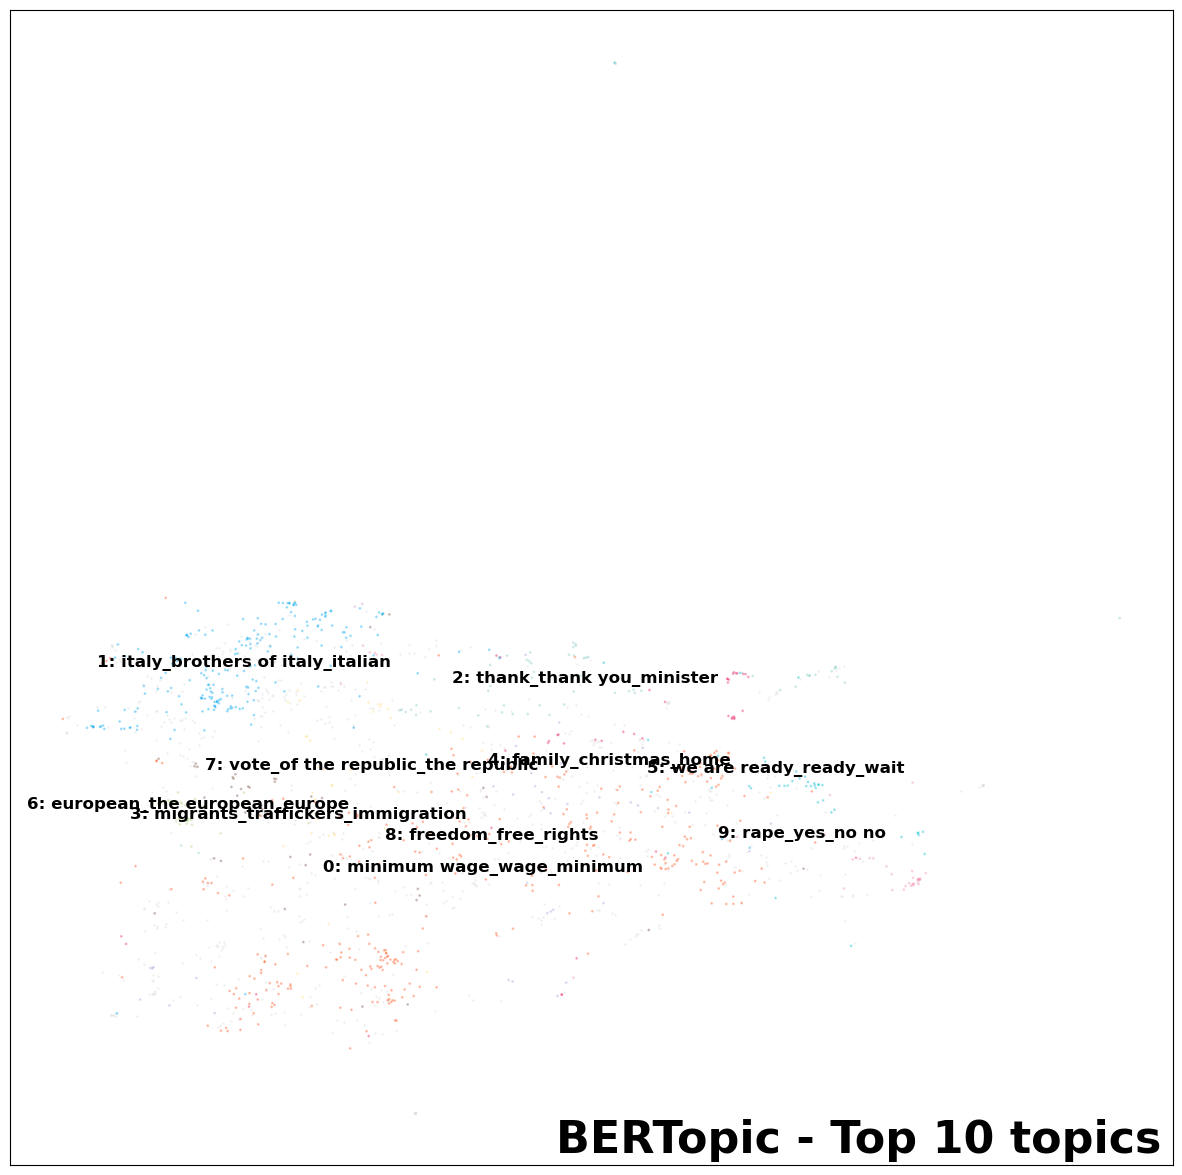

In [427]:

# Prepare data for plotting
embeddings = topic_model._extract_embeddings(docs, method="document")
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics

# Plot parameters
top_n = 10
fontsize = 12

# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                         '#03A9F4', # Blue
                                         '#4CAF50', # Green
                                         '#80CBC4', # FFEB3B
                                         '#673AB7', # Purple
                                         '#795548', # Brown
                                         '#E91E63', # Pink
                                         '#212121', # Black
                                         '#00BCD4', # Light Blue
                                         '#CDDC39', # Yellow/Red
                                         '#AED581', # Light Green
                                         '#FFE082', # Light Orange
                                         '#BCAAA4', # Light Brown
                                         '#B39DDB', # Light Purple
                                         '#F48FB1', # Light Pink
                                         ])

# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
    topic = int(row[1].topic)
    text = f"{topic}: " + "_".join([x[0] for x in topic_model.get_topic(topic)[:3]])
    ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [ ]:
topic_model.hierarchical_topics(docs)

# semi supervised topics model
# topic_model.fit(docs, y = y)

# incremental topic modelling
# topic_model.partial_fit(docs)

# Dynamci topics topics over time
# topic_model.topics_over_time(docs, timestamps=)

# class based topic modelling
# topic_model.topics_per_class(docs, classes)
# The stop word vec taht does nto work.
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
topic_model.get_topic_info().head(50)

## Analyse Individual Topics 

In [ ]:
topic_model.get_topic(11, full=True)